In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('../Student_performance_data.csv')
df.drop(columns='StudentID', inplace=True)
categorical_columns = ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GradeClass']
for col in categorical_columns:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                2392 non-null   int64   
 1   Gender             2392 non-null   category
 2   Ethnicity          2392 non-null   category
 3   ParentalEducation  2392 non-null   category
 4   StudyTimeWeekly    2392 non-null   float64 
 5   Absences           2392 non-null   int64   
 6   Tutoring           2392 non-null   category
 7   ParentalSupport    2392 non-null   category
 8   Extracurricular    2392 non-null   category
 9   Sports             2392 non-null   category
 10  Music              2392 non-null   category
 11  Volunteering       2392 non-null   category
 12  GPA                2392 non-null   float64 
 13  GradeClass         2392 non-null   category
dtypes: category(10), float64(2), int64(2)
memory usage: 99.8 KB


In [5]:
df['GradeClass'].value_counts()

GradeClass
4.0    1211
3.0     414
2.0     391
1.0     269
0.0     107
Name: count, dtype: int64

In [6]:

targetColumn = df['GradeClass']
otherColumns = df.drop(columns=targetColumn.name)

xTrain, xTest, yTrain, yTest = train_test_split(otherColumns, targetColumn, test_size=0.2, stratify=targetColumn, random_state=1)
otherColumns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                2392 non-null   int64   
 1   Gender             2392 non-null   category
 2   Ethnicity          2392 non-null   category
 3   ParentalEducation  2392 non-null   category
 4   StudyTimeWeekly    2392 non-null   float64 
 5   Absences           2392 non-null   int64   
 6   Tutoring           2392 non-null   category
 7   ParentalSupport    2392 non-null   category
 8   Extracurricular    2392 non-null   category
 9   Sports             2392 non-null   category
 10  Music              2392 non-null   category
 11  Volunteering       2392 non-null   category
 12  GPA                2392 non-null   float64 
dtypes: category(9), float64(2), int64(2)
memory usage: 97.2 KB


In [7]:
estimators = [('encoder', TargetEncoder()),
              ('clf', XGBClassifier(random_state = 1))] #XGBRegressor for regression problem

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [8]:
searchSpace = {
    'clf__max_depth': Integer(2, 6),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, searchSpace, cv=5, n_iter=20, scoring='roc_auc_ovr', random_state=1, refit=True)

Train the model

In [9]:
opt.fit(xTrain, yTrain)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       feature_weights=None,
                                                       gamma=None,
                                                       grow_policy=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [10]:
opt.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['Gender', 'Ethnicity', 'ParentalEducation',
                                     'Tutoring', 'ParentalSupport',
                                     'Extracurricular', 'Sports', 'Music',
                                     'Volunteering'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.7400997321419567,
                               colsample_bynode=0.7705684495263054,
                               colsample_bytree=0.6115358959667156, device...
                               gamma=1.8950835244973405, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.024138864530655574, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [11]:
opt.best_score_

np.float64(0.9250386216012034)

In [12]:
opt.score(xTest, yTest)

np.float64(0.9201732070260491)

In [13]:
print(yTest)
opt.predict(xTest)

832     4.0
427     4.0
1374    4.0
574     4.0
1482    4.0
       ... 
41      2.0
170     4.0
28      2.0
45      2.0
989     3.0
Name: GradeClass, Length: 479, dtype: category
Categories (5, float64): [0.0, 1.0, 2.0, 3.0, 4.0]


array([4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 1, 4, 1, 1, 4, 4, 4, 4, 4, 2, 4, 4,
       3, 4, 3, 4, 4, 4, 4, 4, 1, 2, 3, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4,
       2, 4, 4, 2, 3, 4, 4, 2, 4, 4, 2, 2, 1, 4, 4, 4, 4, 4, 3, 3, 3, 4,
       2, 3, 1, 4, 4, 2, 4, 4, 3, 4, 4, 3, 4, 4, 2, 4, 3, 4, 4, 4, 1, 3,
       3, 2, 3, 2, 1, 4, 4, 4, 1, 4, 4, 1, 4, 1, 4, 4, 4, 1, 3, 4, 1, 4,
       3, 4, 3, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 2, 4, 3,
       4, 3, 4, 2, 1, 2, 2, 4, 3, 2, 1, 3, 4, 1, 2, 2, 4, 4, 3, 4, 4, 4,
       2, 1, 4, 1, 1, 4, 0, 1, 3, 0, 3, 4, 3, 1, 0, 2, 2, 0, 3, 2, 3, 4,
       3, 4, 4, 4, 4, 3, 4, 4, 2, 3, 4, 4, 4, 3, 4, 4, 4, 4, 2, 1, 4, 1,
       3, 4, 4, 4, 1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 3, 4, 1, 4, 4, 4,
       2, 3, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 2, 1, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 1, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 4, 3,
       4, 4, 2, 0, 4, 3, 4, 1, 3, 2, 4, 1, 3, 2, 4, 2, 4, 2, 0, 1, 2, 1,
       3, 4, 4, 3, 1, 3, 4, 4, 4, 4, 1, 4, 3, 3, 2,

In [14]:
opt.predict_proba(xTest)

array([[0.07001644, 0.09210195, 0.11771397, 0.15269345, 0.5674742 ],
       [0.06001244, 0.07714049, 0.08689797, 0.09564482, 0.6803043 ],
       [0.06165198, 0.07737991, 0.08670874, 0.09543655, 0.6788228 ],
       ...,
       [0.0903541 , 0.11163327, 0.41217336, 0.2026617 , 0.18317756],
       [0.08384238, 0.1245526 , 0.41975528, 0.19280103, 0.1790487 ],
       [0.08906388, 0.15573202, 0.19830014, 0.3638024 , 0.19310154]],
      shape=(479, 5), dtype=float32)

Feature importance 

In [15]:
opt.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring',
                      'ParentalSupport', 'Extracurricular', 'Sports', 'Music',
                      'Volunteering'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.7400997321419567,
                colsample_bynode=0.7705684495263054,
                colsample_bytree=0.6115358959667156, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=1.8950835244973405, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.024138864530655574,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
          

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

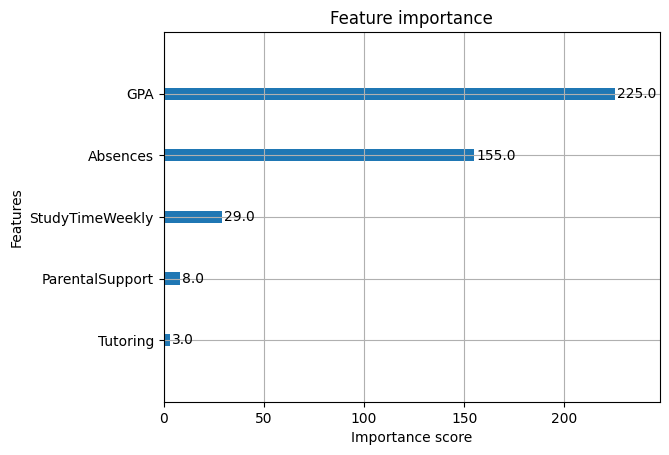

In [16]:
plot_importance(opt.best_estimator_.steps[1][1])

<Axes: >

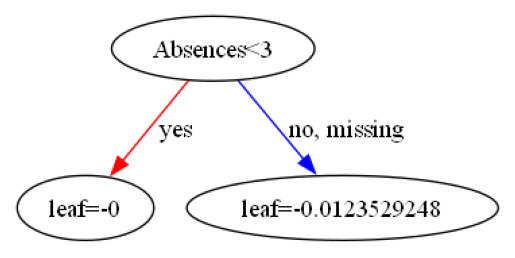

In [17]:
#plot_tree(opt[1], num_trees=2)
plot_tree(opt.best_estimator_[1], tree_idx=5)